In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(stringr))
library(parallel)
library(reshape2)
source('/home//workspace/IHA_Figure_Revision/helper_function/helper_function_IHA.r')

Warning message:
“package ‘dplyr’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘tibble’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘reshape2’ was built under R version 4.3.3”

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [2]:
color_annotation<-read.csv('/home/workspace/IHA_Figure_Revision/Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_annotation$label<-gsub(" cell",'',color_annotation$label)
color_vector <- setNames(color_annotation$color, color_annotation$label)

In [3]:
meta_data=read.csv("Copy of Table S1 Cohort Details - Qiu.csv")

In [4]:
unique(meta_data$Group)

[1] "Control (HC1)"        "ACPA+ At-risk (ARI)"  "ACPA+ Early RA (ERA)"
[4] "Control (HC2)"        ""

In [5]:
files <- list.files("sample_normalized_count_average/", full.names = FALSE)
file_names <- tools::file_path_sans_ext(files)

In [6]:
meta_data<-meta_data %>% filter(Time.to.clinical.RA.diagnosis..days.!=0)%>% filter(Sample.ID %in% file_names,Group %in% c(
                                                                       'ACPA+ At-risk (ARI)'
                                                                       ))

In [7]:
meta_data_duplicated <- meta_data[duplicated(meta_data$Subject.ID) | duplicated(meta_data$Subject.ID, fromLast = TRUE), ]

In [8]:
colnames(meta_data_duplicated)

[1] "Group"                                                         
 [2] "Subject.ID"                                                    
 [3] "Converter.Status"                                              
 [4] "Sample.ID"                                                     
 [5] "Age.at.sample.collection..yrs."                                
 [6] "Age.at.diagnosis.of.clinical.RA..yrs."                         
 [7] "BMI"                                                           
 [8] "BMI.at.diagnosis.of.clinical.RA"                               
 [9] "Sex"                                                           
[10] "Anti.CCP3..units."                                             
[11] "Rheumatoid.factor..RF..IgA..U.mL."                             
[12] "Rheumatoid.factor..RF..IgM..U.mL."                             
[13] "Time.to.clinical.RA.diagnosis..days."                          
[14] "Time.from.initial.visit.to.sample.collection..days."           
[15] "Alanine.transaminase..ALT..U.L."                               
[16] "Albumin..g.dL."                                                
[17] "Alkaline.phosphatase..IU.L."                                   
[18] "Anion.gap..mEq.L."                                             
[19] "High.sensitivity.C.reactive.protein..hs.CRP..mg.L."            
[20] "High.density.lipoprotein..HDL..mg.dL."                         
[21] "Low.density.lipoprotein..LDL..mg.dL."                          
[22] "Total.cholesterol..mg.dL."                                     
[23] "Platelet.count..10.3.uL."                                      
[24] "Total.protein..g.dL."                                          
[25] "Red.blood.cell..RBC..count..10.6.uL."                          
[26] "Erythrocyte.sedimentation.rate...Westergren.method..ESR..mm.h."
[27] "Shared.epitope"                                                
[28] "Sodium..mmol.L."                                               
[29] "Triglycerides..mg.dL."                                         
[30] "White.blood.cell..WBC..count..10.3.uL."                        
[31] "Used.in.Longtinudinal.analysis"                                
[32] "Used.in.cross.sectional.analysis"                              
[33] "Used.in.TEA.seq.experiment"                                    
[34] "Used.in.B.cells.activation.experiment"                         
[35] "Used.in.T.cell.phenotyping.experiment"                         
[36] "Used.in.VDJ.experiment"

In [9]:
meta_data <- meta_data_duplicated %>%
  arrange(Subject.ID, Time.to.clinical.RA.diagnosis..days.) %>%
  group_by(Subject.ID) %>%
  mutate(row_number = row_number(),
         total_rows = n()) %>%
  filter(row_number == 1 | row_number == total_rows) %>%
  mutate(Annotation = if_else(row_number == 1, "first", "last")) %>%
  ungroup() 


In [10]:
meta_data$pbmc_sample_id<-meta_data$Sample.ID

In [11]:
file_list<-paste0("sample_normalized_count_average/", meta_data$pbmc_sample_id, ".csv")

In [12]:
df_list<-read_pseudobulk_expression(file_list,
                                    mc_cores = 15)

[1] "Total reading time: 5.58999999999992 seconds"
[1] "The length of the list matches the length of the input path."


In [13]:
deseq2_result_Y1D0<-read.csv('/home//workspace/IHA_Figure_Revision/Figure1/02_DEG/Deseq2_Result_Y1D0.csv')

In [14]:
 #filter significant genes 
deseq2_result_Y1D0_AgeGroup_sig<-deseq2_result_Y1D0 %>% 
  filter(contrast == "cohort.cohortGuid") %>%
  filter(padj < 0.05, 
         abs(log2FoldChange) > 0.1)

In [15]:
df_degs_counts<-as.data.frame(table(deseq2_result_Y1D0_AgeGroup_sig$celltype,
                                    deseq2_result_Y1D0_AgeGroup_sig$Direction))

In [16]:
df_degs_counts_filtered<-df_degs_counts %>% filter(Var2=="HigherInBR2") %>% arrange(Var1)   %>% filter(Freq>20)

In [17]:
score_df_list <- mclapply(unique(df_degs_counts_filtered$Var1), function(celltype_single) {
    top_n <- 100
    Direction_of_DEG <- "HigherInBR2"
    
    selected_genes <- deseq2_result_Y1D0_AgeGroup_sig %>%
        filter(celltype == celltype_single, Direction == Direction_of_DEG) %>%
        arrange(padj, desc(abs(log2FoldChange))) %>% 
        slice_head(n = top_n) %>%
        select(gene) %>%
        pull()
    selected_genes<-intersect(selected_genes,rownames(df_list[[1]]))
    print(length(selected_genes))
    long_format <- filter_genes_and_celltype(df_list, selected_genes, celltype_single, longformat = TRUE) %>%
        left_join(meta_data) %>%
        filter(!is.na(Mean_Expression)) %>%
        group_by(Gene) %>%
        mutate(Z_score_Mean_Expression = scale(Mean_Expression)) %>%
        ungroup()
    
    composite_score_df <- long_format %>%
        group_by(pbmc_sample_id) %>%
        summarise(
            composite_score_sum_mean = sum(Mean_Expression, na.rm = TRUE),
            composite_score_sum_scaled_mean = sum(Z_score_Mean_Expression, na.rm = TRUE)
        ) %>%
        left_join(meta_data) %>%
        mutate(celltype = celltype_single) %>%
        as.data.frame()
    
    return(composite_score_df)
}, mc.cores = 10)


In [18]:
composite_score_df_all<-do.call(rbind,score_df_list)

In [19]:
library(ggpubr)

In [20]:
options(repr.plot.width = 250/25.4, repr.plot.height = 220/25.4)


Warning message in wilcox.test.default(c(56, 42, 21, 58, 66, 65, 36, 31, 46, 33, :
“cannot compute exact p-value with ties”


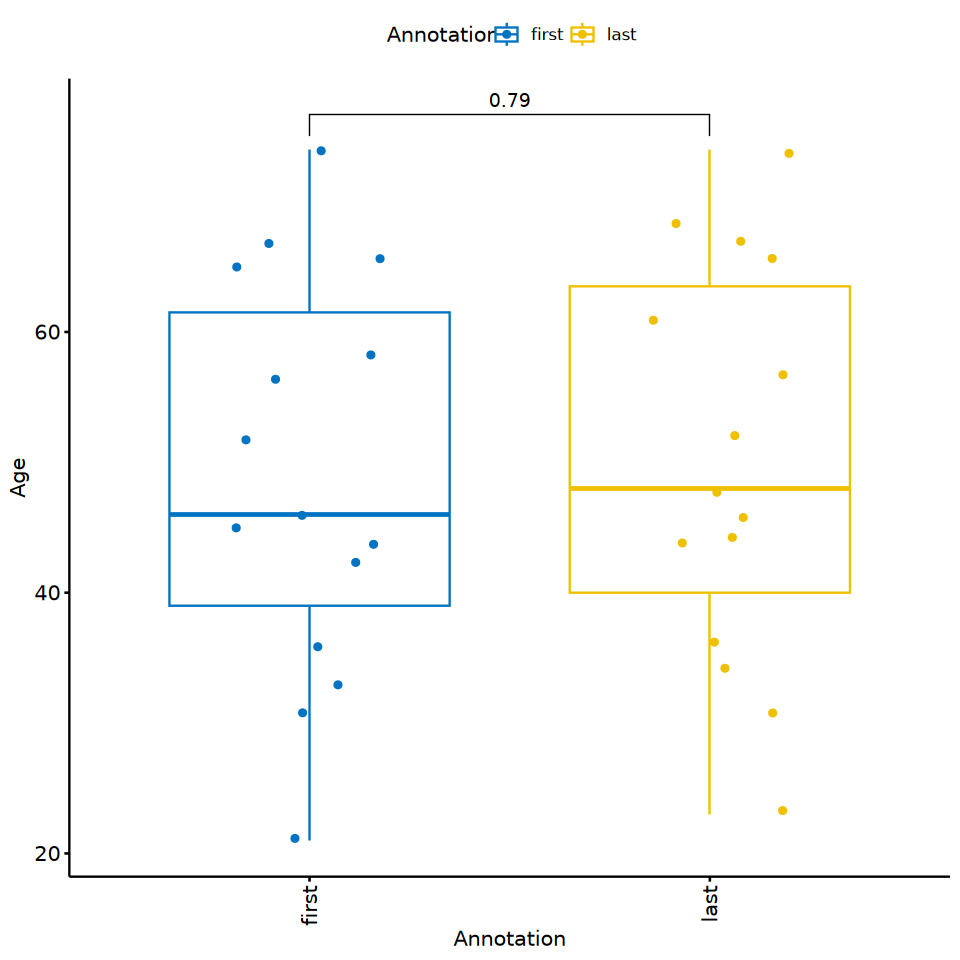

In [21]:
group_levels <- levels(factor(composite_score_df_all$Annotation))
my_comparisons <- combn(group_levels, 2, simplify = FALSE)
options(repr.plot.width = 8, repr.plot.height = 8)

p <- ggboxplot(composite_score_df_all %>% filter(celltype=="CM CD8 T cell"), x = "Annotation", y = "Age.at.sample.collection..yrs.",
               color = "Annotation", palette = "jco", add = "jitter") +
     stat_compare_means(method = "wilcox.test", comparisons = my_comparisons, 
                        group.by = "celltype") + 
theme(axis.text.x = element_text(angle = 90, 
                                                                                  vjust = 0.5, hjust=1))+ylab("Age")

p

In [23]:
composite_score_df_all

pbmc_sample_id,composite_score_sum_mean,composite_score_sum_scaled_mean,Group,Subject.ID,Converter.Status,Sample.ID,Age.at.sample.collection..yrs.,Age.at.diagnosis.of.clinical.RA..yrs.,BMI,⋯,Used.in.Longtinudinal.analysis,Used.in.cross.sectional.analysis,Used.in.TEA.seq.experiment,Used.in.B.cells.activation.experiment,Used.in.T.cell.phenotyping.experiment,Used.in.VDJ.experiment,row_number,total_rows,Annotation,celltype
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<fct>
KT00052,55.01660,56.90849114,ACPA+ At-risk (ARI),ARI36,CONV,KT00052,56,58,24.65716,⋯,Yes,Yes,No,No,No,No,1,3,first,CM CD4 T cell
KT00056,52.20316,-3.09912209,ACPA+ At-risk (ARI),ARI46,CONV,KT00056,42,44,25.94834,⋯,Yes,Yes,No,No,No,No,1,4,first,CM CD4 T cell
KT00057,52.35565,7.07031549,ACPA+ At-risk (ARI),ARI35,CONV,KT00057,21,23,21.12653,⋯,Yes,Yes,No,No,Yes,No,1,5,first,CM CD4 T cell
KT00064,55.27195,50.58825164,ACPA+ At-risk (ARI),ARI41,CONV,KT00064,58,62,22.76795,⋯,Yes,Yes,No,No,No,No,1,5,first,CM CD4 T cell
KT00075,52.90905,12.91095944,ACPA+ At-risk (ARI),ARI43,CONV,KT00075,66,68,28.10807,⋯,Yes,Yes,No,No,No,No,1,8,first,CM CD4 T cell
KT00084,52.72037,8.10584168,ACPA+ At-risk (ARI),ARI37,CONV,KT00084,65,66,27.61246,⋯,Yes,Yes,No,No,Yes,No,1,3,first,CM CD4 T cell
KT00103,54.43133,47.35858628,ACPA+ At-risk (ARI),ARI32,CONV,KT00103,36,36,25.84777,⋯,Yes,No,No,No,Yes,No,2,2,last,CM CD4 T cell
KT00105,51.54248,-1.92954307,ACPA+ At-risk (ARI),ARI33,CONV,KT00105,31,32,23.24341,⋯,Yes,No,No,No,No,No,2,2,last,CM CD4 T cell
KT00114,53.96486,44.48451985,ACPA+ At-risk (ARI),ARI32,CONV,KT00114,36,36,26.23173,⋯,Yes,Yes,No,No,Yes,No,1,2,first,CM CD4 T cell


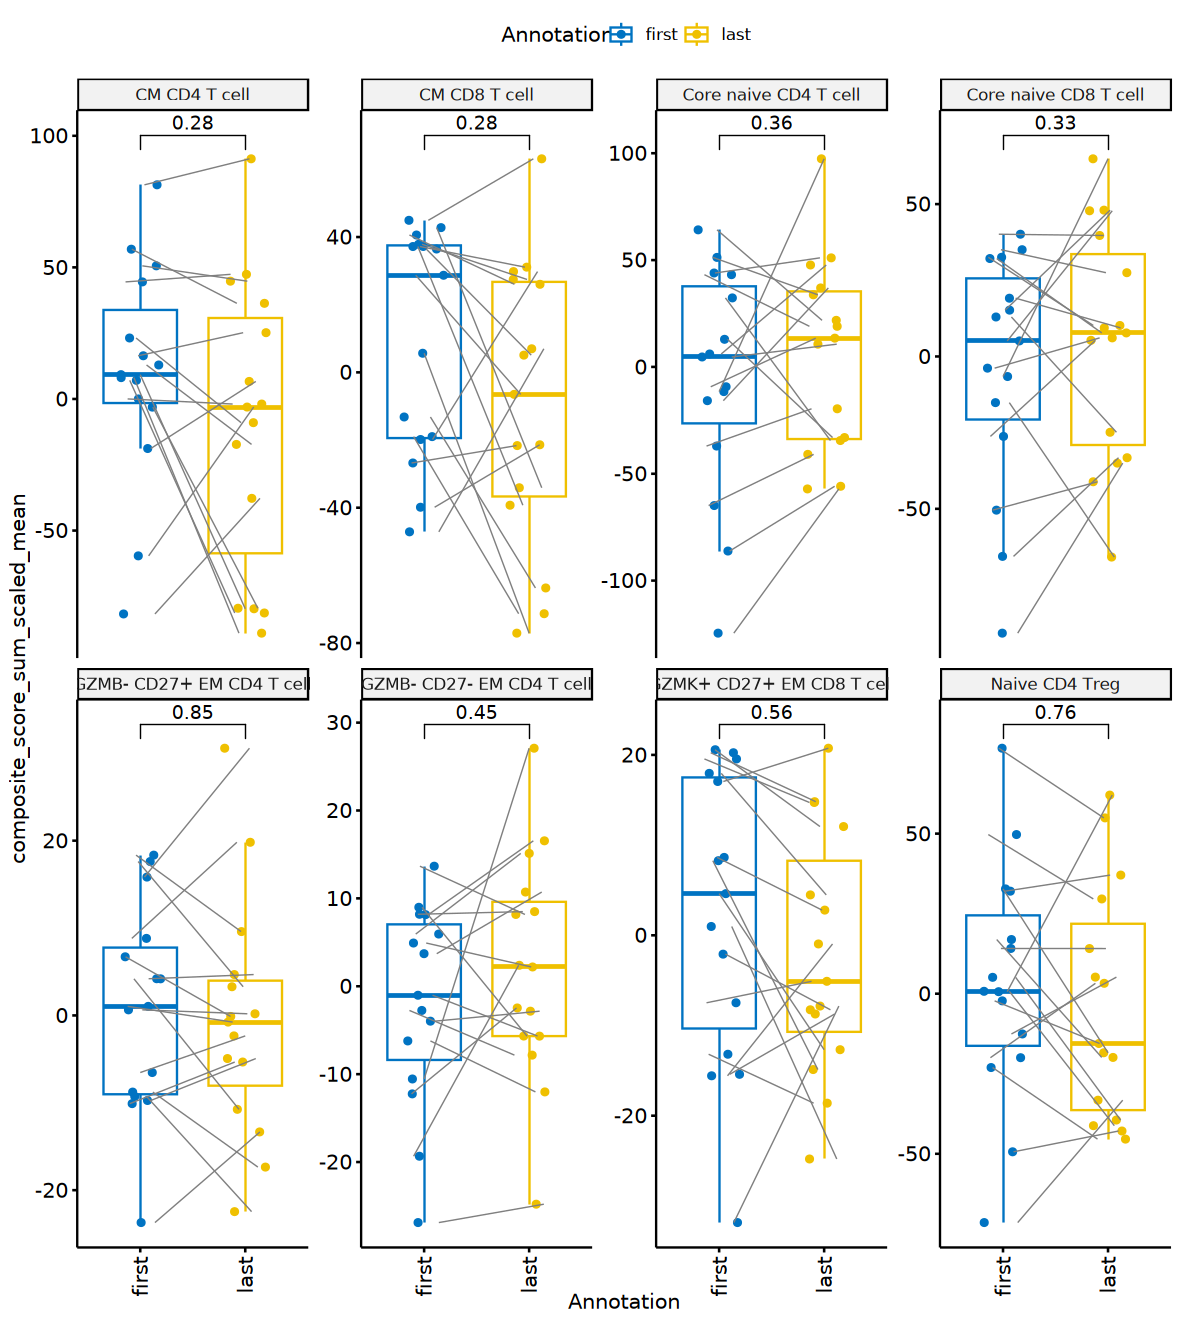

In [24]:

options(repr.plot.width = 250/25.4, repr.plot.height = 280/25.4)

group_levels <- levels(factor(composite_score_df_all$Annotation))
my_comparisons <- combn(group_levels, 2, simplify = FALSE)

p <- ggboxplot(composite_score_df_all, 
               x = "Annotation", 
               y = "composite_score_sum_scaled_mean",
               color = "Annotation", palette = "jco", add = "jitter") +
     stat_compare_means(method = "wilcox.test", 
                        comparisons = my_comparisons, 
                        group.by = "celltype", 
                        paired = TRUE) +
     geom_line(aes(group = Subject.ID	), 
               position = position_dodge(0.3), 
               color = "gray50", 
               linewidth = 0.3) +
     facet_wrap(~celltype,
                ncol = 4,
                scale = "free_y") + 
     theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))

p